In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#conda install -c conda-forge xgboost 

import warnings
warnings.filterwarnings("ignore")

In [11]:
#pip install pip==23.1

In [12]:
#!pip3 install xgboost

In [66]:
# Read the data
benchmark=pd.read_csv('home-data-for-ml-course/sample_submission.csv')
X = pd.read_csv('home-data-for-ml-course/train.csv', index_col='Id')
X_test_full = pd.read_csv('home-data-for-ml-course/test.csv', index_col='Id')

### EDA

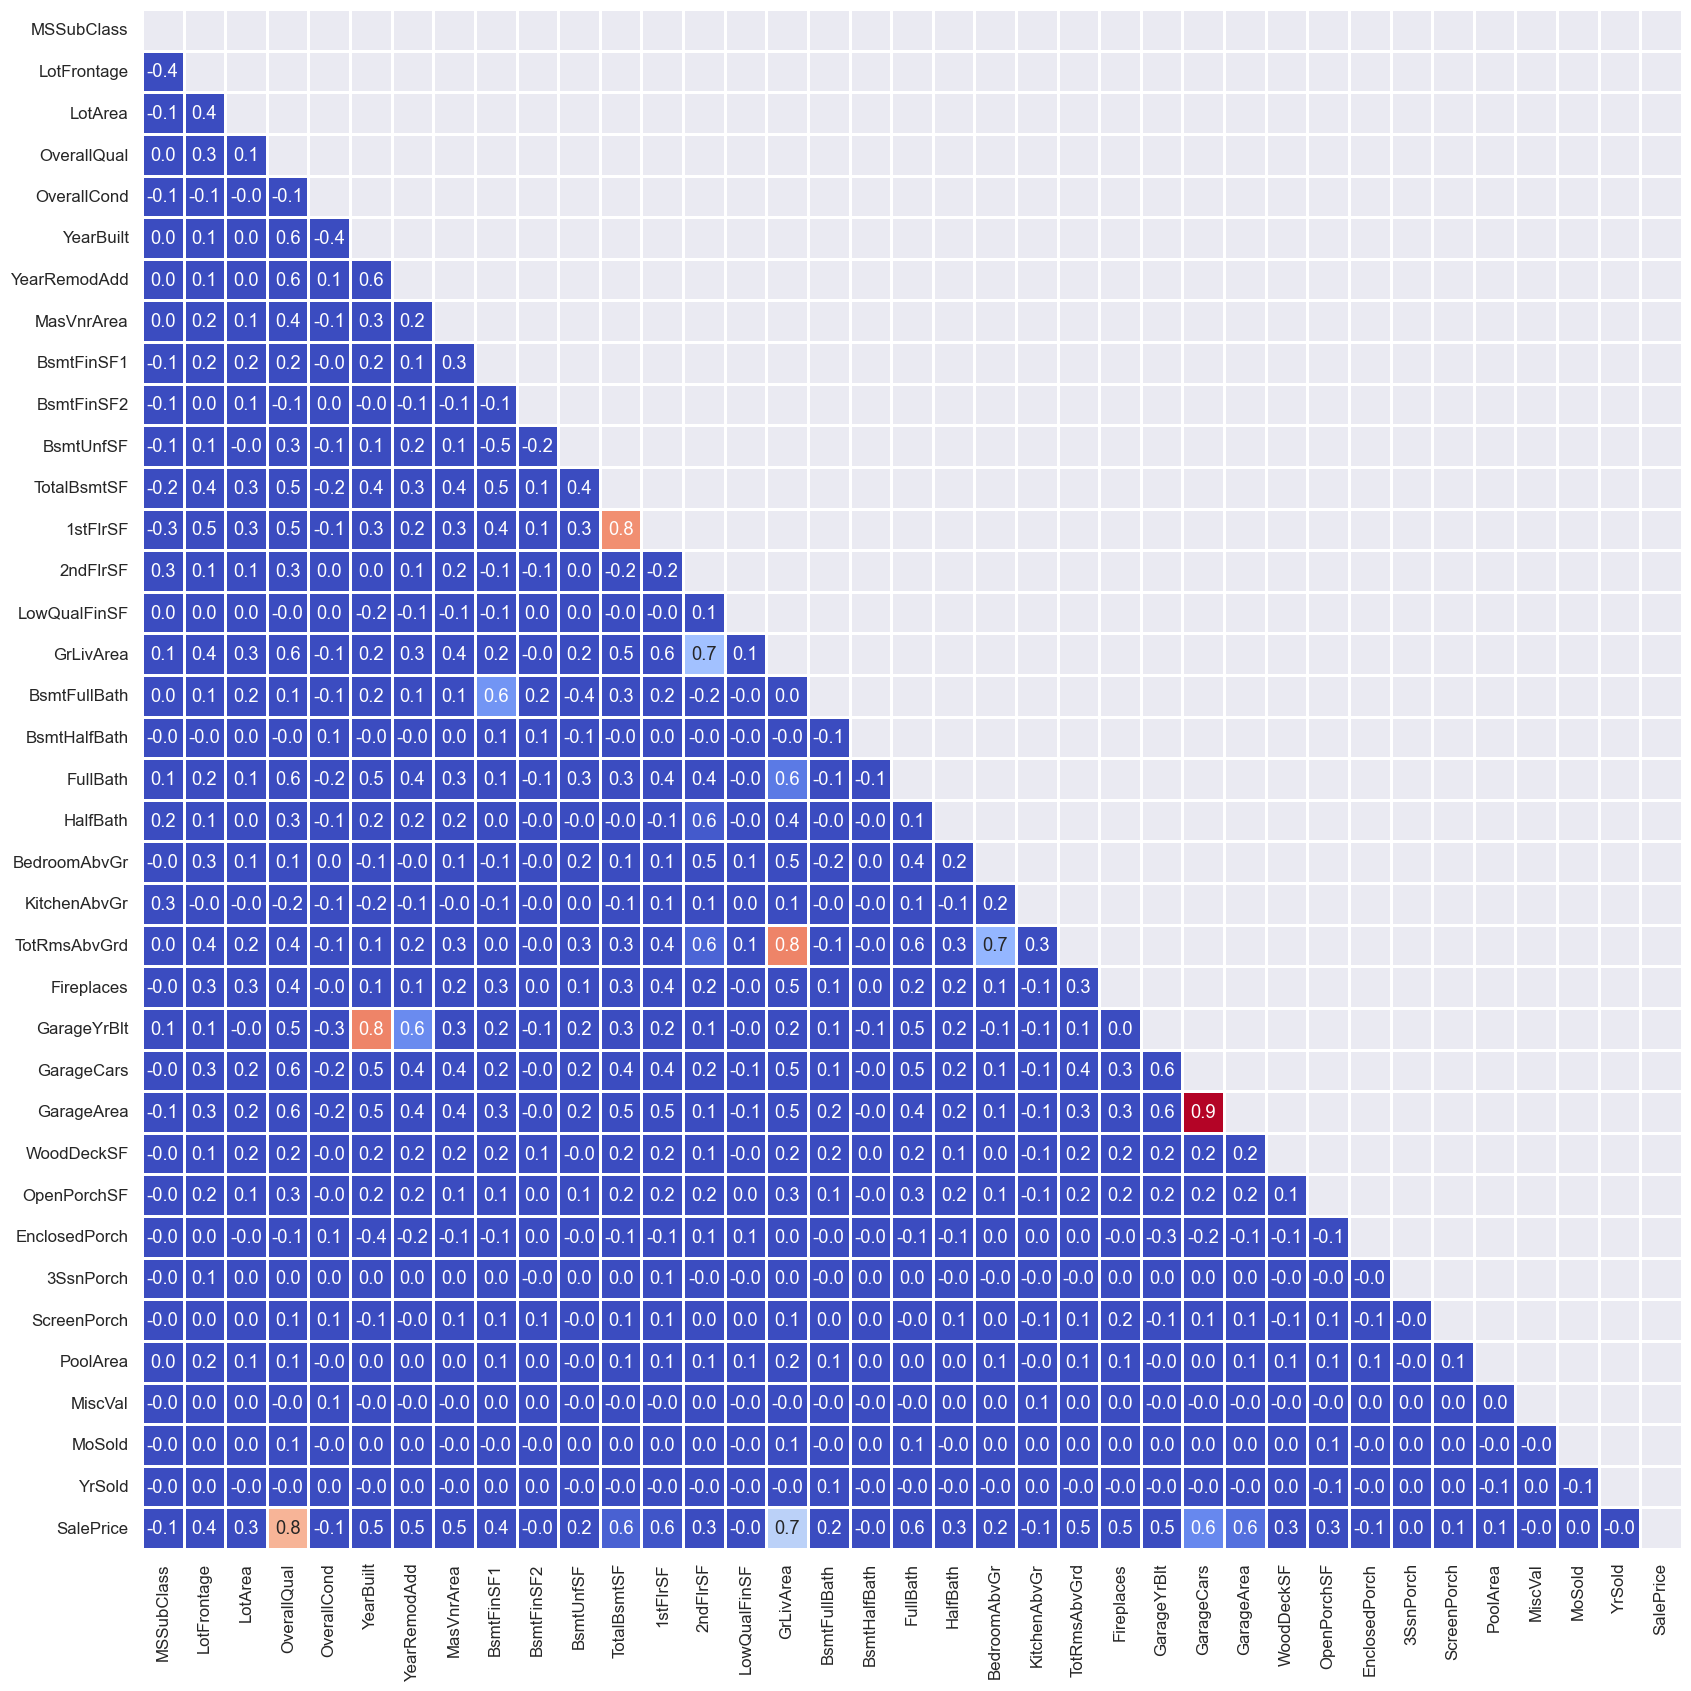

In [119]:
sns.set(font_scale=1.1)
correlation_train = X.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False,
            vmin=0.6)

plt.show()

In [67]:
drop_list=['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars']

In [4]:
missing=X.isnull().sum().sort_values(ascending=False)/X.shape[0]
missing=pd.DataFrame(missing)
missing.rename(columns={0:'value'},inplace=True)
missing=missing[missing.value>0]
missing

value
PoolQC        0.995205
MiscFeature   0.963014
Alley         0.937671
Fence         0.807534
FireplaceQu   0.472603
LotFrontage   0.177397
GarageYrBlt   0.055479
GarageCond    0.055479
GarageType    0.055479
GarageFinish  0.055479
GarageQual    0.055479
BsmtExposure  0.026027
BsmtFinType2  0.026027
BsmtCond      0.025342
BsmtQual      0.025342
BsmtFinType1  0.025342
MasVnrArea    0.005479
MasVnrType    0.005479
Electrical    0.000685

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'PoolQC'),
  Text(1, 0, 'MiscFeature'),
  Text(2, 0, 'Alley'),
  Text(3, 0, 'Fence'),
  Text(4, 0, 'FireplaceQu'),
  Text(5, 0, 'LotFrontage'),
  Text(6, 0, 'GarageYrBlt'),
  Text(7, 0, 'GarageCond'),
  Text(8, 0, 'GarageType'),
  Text(9, 0, 'GarageFinish'),
  Text(10, 0, 'GarageQual'),
  Text(11, 0, 'BsmtExposure'),
  Text(12, 0, 'BsmtFinType2'),
  Text(13, 0, 'BsmtCond'),
  Text(14, 0, 'BsmtQual'),
  Text(15, 0, 'BsmtFinType1'),
  Text(16, 0, 'MasVnrArea'),
  Text(17, 0, 'MasVnrType'),
  Text(18, 0, 'Electrical')])

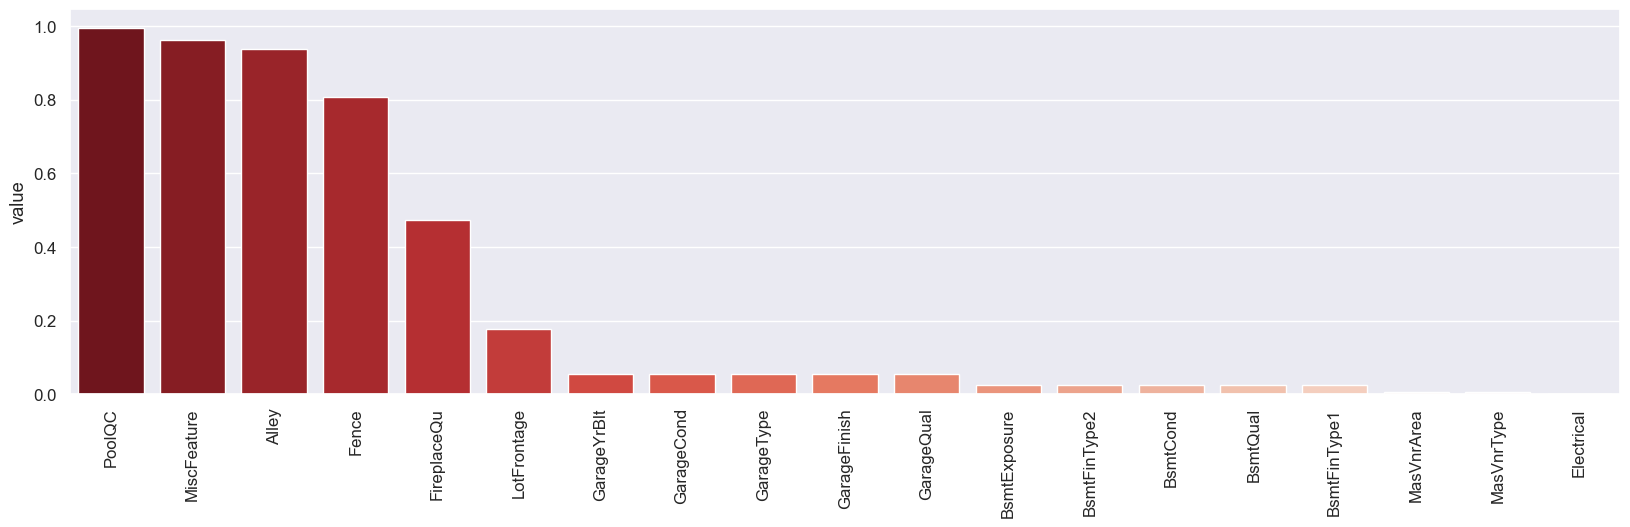

In [122]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y=missing.value, data=missing, palette='Reds_r')
plt.xticks(rotation=90)

In [68]:
### Missing values
none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]#

zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageArea', 'MasVnrArea','GarageCars'
]# 'GarageCars',

freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities']

median_cols= ['GarageYrBlt','LotFrontage']

# Filling the list of columns above with appropriate values:

for col in zero_cols:
    X[col].fillna( 0, inplace=True)
    X_test_full[col].fillna( 0, inplace=True)
for col in none_cols:
    X[col].fillna('None', inplace=True)
    X_test_full[col].fillna( 'None', inplace=True)
for col in median_cols:
    X[col].fillna(X[col].median(), inplace=True)
    X_test_full[col].fillna(X_test_full[col].median(), inplace=True)
for col in freq_cols:
    X[col].fillna(X[col].mode()[0], inplace=True)
    X_test_full[col].fillna( X_test_full[col].mode()[0], inplace=True)
    
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))   
X_test_full['MSZoning'] = X_test_full.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))
missing2=X.isnull().sum().sort_values(ascending=False)/X.shape[0]
missing2=pd.DataFrame(missing2)
missing2.rename(columns={0:'value'},inplace=True)
missing2=missing2[missing2.value>0]
missing2
X.isnull().sum().sort_values(ascending=False)/X_test_full.shape[0]

MSSubClass     0.0
MSZoning       0.0
GarageYrBlt    0.0
GarageType     0.0
FireplaceQu    0.0
              ... 
MasVnrArea     0.0
MasVnrType     0.0
Exterior2nd    0.0
Exterior1st    0.0
SalePrice      0.0
Length: 80, dtype: float64

In [69]:
drop_list=list(set(drop_list+list(missing2[missing2.value>0.90].index)))

In [70]:
#len1=len(X.columns)
X.drop(drop_list, axis=1, inplace=True)
X_test_full.drop(drop_list, axis=1, inplace=True)
#len2=len(X.columns)
#len1-len2

In [71]:
X['MSSubClass'] = X['MSSubClass'].astype(str)
X_test_full['MSSubClass'] = X_test_full['MSSubClass'].astype(str)

X['MoSold'] = X['MoSold'].astype(str)
X_test_full['MoSold'] = X_test_full['MoSold'].astype(str)


In [196]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', '

In [144]:
#set(X['Condition1'])
#X['Condition1'].value_counts()
X['Condition1'].isin(
        X['Condition1'].value_counts()[X['Condition1'].value_counts() < 10].index)

Id
1       False
2       False
3       False
4       False
5       False
        ...  
1456    False
1457    False
1458    False
1459    False
1460    False
Name: Condition1, Length: 1460, dtype: bool

### Categorical feature

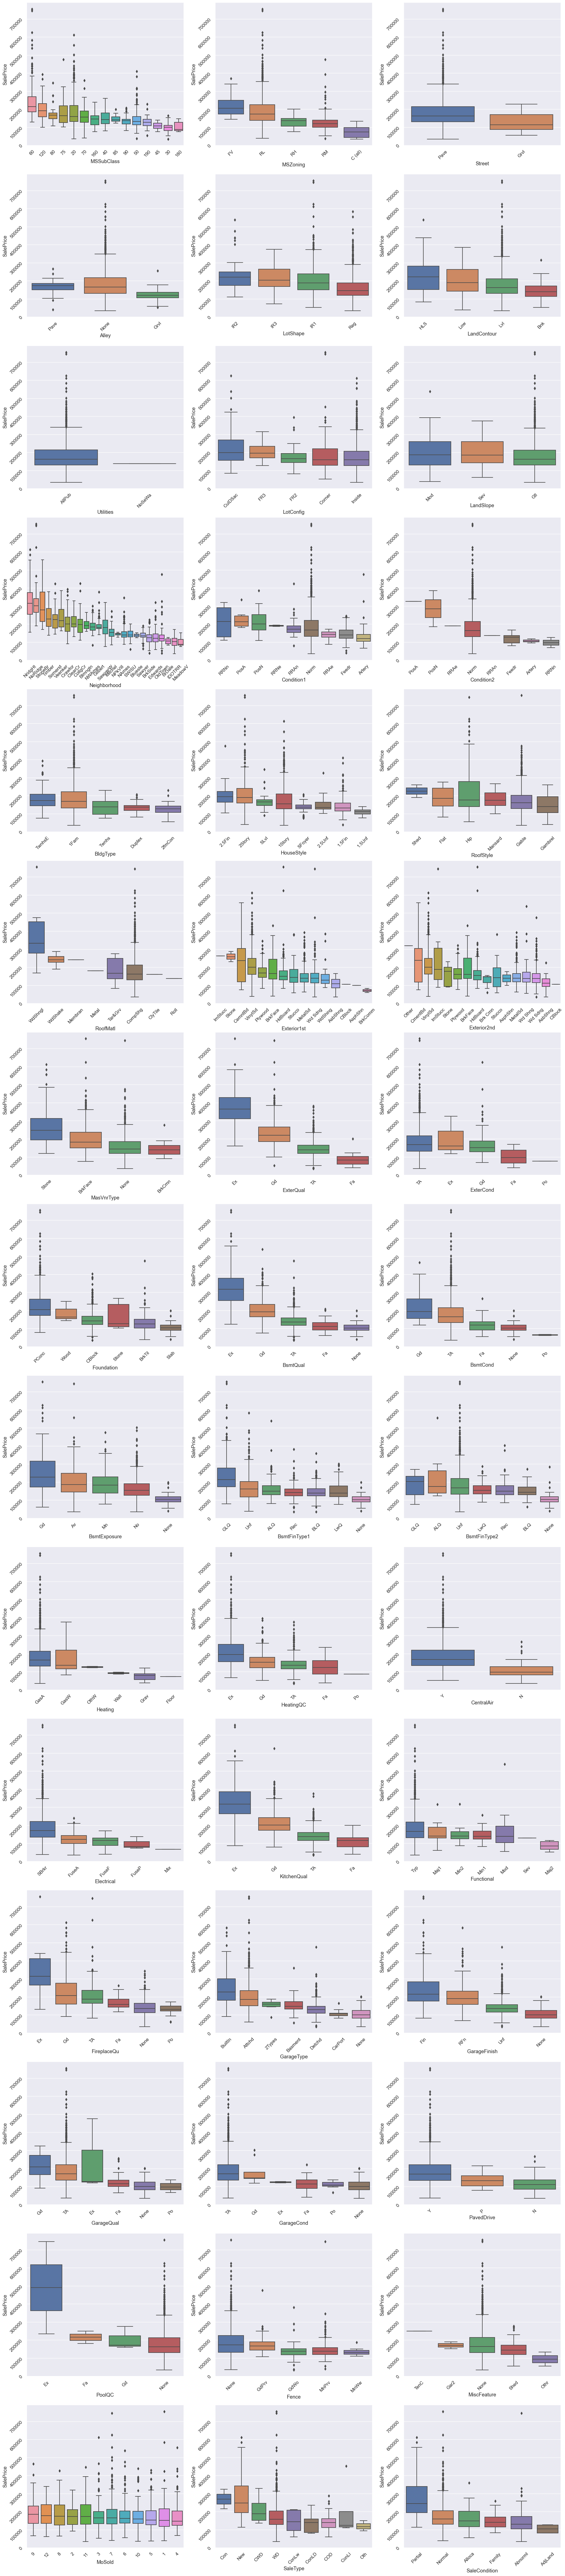

In [221]:
cat_features=X.select_dtypes(include=['object']).columns
cat_features

fig, axes = plt.subplots(15, 3, figsize=(25, 120))
axes = axes.flatten()
for feature,axe in zip(cat_features,axes):
    sortd = X.groupby([feature])['SalePrice'].median().sort_values(ascending=False)
    sns.boxplot(X[feature],X['SalePrice'],ax=axe,order=sortd.index)
    axe.tick_params(labelrotation=45)
  

#### Converting some categorical features to numerical to improve linear relationship.

In [9]:
X['BsmtCond']

Id
1       TA
2       TA
3       TA
4       Gd
5       TA
        ..
1456    TA
1457    TA
1458    Gd
1459    TA
1460    TA
Name: BsmtCond, Length: 1460, dtype: object

In [72]:
bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
convert_cat1=['BsmtQual','BsmtCond','ExterQual',
              'ExterCond','HeatingQC','KitchenQual',
              'FireplaceQu','GarageCond','GarageQual','PoolQC']
for cat in convert_cat1:
    X[cat] = X[cat].map(bsm_map).astype('int')
    X_test_full[cat] = X_test_full[cat].map(bsm_map).astype('int')


bsmf_map = {'None': 0,'Unf': 1,'LwQ': 2,'Rec': 3,'BLQ': 4,'ALQ': 5,'GLQ': 6}   
X['BsmtFinType1'] = X['BsmtFinType1'].map(bsmf_map).astype('int')    
X_test_full['BsmtFinType1'] = X_test_full['BsmtFinType1'].map(bsmf_map).astype('int')
X['BsmtFinType2'] = X['BsmtFinType2'].map(bsmf_map).astype('int')
X_test_full['BsmtFinType2'] = X_test_full['BsmtFinType2'].map(bsmf_map).astype('int')


#Doesn't improve much predictions but allows to keep this feature even if cardinality>10 
neigh_map = {'MeadowV': 1,
             'IDOTRR': 2,'BrDale': 2,
             'BrkSide': 3,'OldTown': 3,'Edwards': 3,
             'Sawyer': 4,'Blueste': 4,'SWISU': 4,'NPkVill': 4,'NAmes': 4,
             'Mitchel': 5,
             'SawyerW': 6,'NWAmes': 6,'Gilbert': 6,
             'Blmngtn': 7,'CollgCr': 7,'ClearCr': 7,'Crawfor': 7,
             'Veenker': 8,'Somerst': 8,'Timber': 8,
             'StoneBr': 9,
             'NridgHt': 10,
             'NoRidge': 11}


X['Neighborhood'] = X['Neighborhood'].map(neigh_map).astype('int')
X_test_full['Neighborhood'] = X_test_full['Neighborhood'].map(neigh_map).astype('int')



### Numerical feature

In [73]:
drop_list

['1stFlrSF', 'GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd']

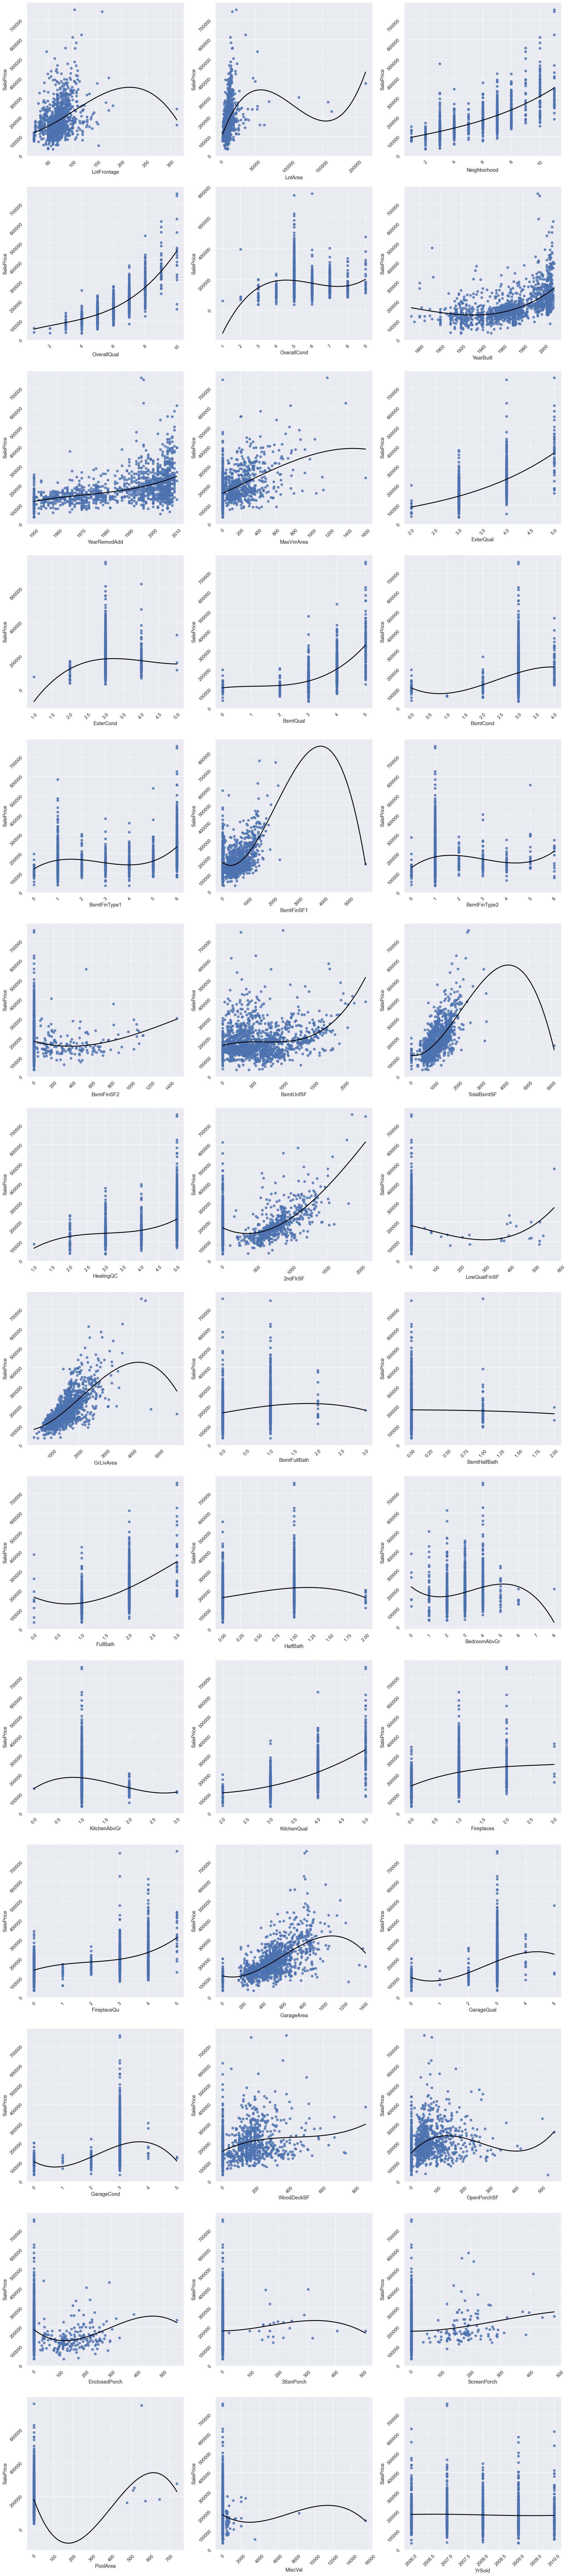

In [224]:
num_features=X.select_dtypes(include=['number']).columns

fig, axes = plt.subplots(14, 3, figsize=(25, 120))
axes = axes.flatten()
for feature,axe in zip(num_features,axes):
    sns.regplot(X[feature],X['SalePrice'],ax=axe,ci=None,order=3,line_kws={'color': 'black'})
    #color='#e74c3c',scatter_kws={'alpha':0.4})
    axe.tick_params(labelrotation=45)

In [74]:
# Dropping outliers after detecting them by eye.

#features = features.join(y)
X = X.drop(X[(X['OverallQual'] < 5) & (X['SalePrice'] > 200000)].index)
#X_test_full = X_test_full.drop(X_test_full[(X_test_full['OverallQual'] < 5)
 #                                          & (X_test_full['SalePrice'] > 200000)].index)

X = X.drop(X[(X['GrLivArea'] > 4000) & (X['SalePrice'] < 200000)].index)
#X_test_full = X_test_full.drop(X_test_full[(X_test_full['GrLivArea'] > 4000) 
 #                                          & (X_test_full['SalePrice'] < 200000)].index)
             
X = X.drop(X[((X['GarageArea'] > 1200) & (X['SalePrice'] < 200000))|(X['SalePrice'] > 700000) ].index)
#X_test_full = X_test_full.drop(X_test_full[((X_test_full['GarageArea'] > 1200) 
 #                                           & (X_test_full['SalePrice'] < 200000))|(X_test_full['SalePrice'] > 700000) ].index)


X = X.drop(X[(X['TotalBsmtSF'] > 4000)].index)
                                 # & (features['SalePrice'] > 320000)].index)
#X_test_full = X_test_full.drop(X_test_full[(X_test_full['TotalBsmtSF'] > 4000)].index) 
                                           

#features = features.drop(features[(features['1stFlrSF'] < 3000)
 #                                 & (features['SalePrice'] > 600000)].index)

#features = features.drop(features[(features['1stFlrSF'] > 3000)
 #                                 & (features['SalePrice'] < 200000)].index)

#y = features['SalePrice']
#y.dropna(inplace=True)
#features.drop(columns='SalePrice', inplace=True)

### Feature Engineering

In [84]:
#Overqual=*HeatingQC*KitchenQual*FireplaceQu***PoolQC*Fence*
#SF=BsmtFinSF1+BsmtFinSF2+BsmtUnfSF+1stFlrSF+2ndFlrSF-LowQualFinSF+GrLivArea+GarageArea+PoolArea
df=[X,X_test_full]
for i in df:
    i['TotalPorchSF'] = i['OpenPorchSF'] + i['3SsnPorch'] + i['EnclosedPorch'] + i['ScreenPorch'] + i['WoodDeckSF']
    i['Garage Qual'] = i['GarageQual'] * i['GarageCond']
    i['Exter Qual'] = i['ExterQual'] * i['ExterCond']
    i['Over Qual'] = i['OverallQual'] * i['OverallCond']
    i['Bsmt Qual'] = i['BsmtQual'] * i['BsmtCond']
    i['Utilities Qual'] = i['HeatingQC'] + i['KitchenQual'] + i['FireplaceQu'] + i['PoolQC'] #+ i['Fence']
    i['Bath']=i['FullBath'] + i['BsmtFullBath'] + 0.5 * (i['HalfBath'] + i['BsmtHalfBath'])
    i['YearBlRm'] = i[['YearBuilt', 'YearRemodAdd']].values.max(1)
    i['TotalSF'] = i['BsmtFinSF1'] + i['BsmtFinSF2'] + i['2ndFlrSF'] #+ i['1stFlrSF']
    #max(i['YearBuilt'],i['YearRemodAdd'],axis=1)

    # Creating new features by using new quality indicators.
 #   i['QualGr'] = (i['Utilities Qual'] + i['Bsmt Qual'] + i['Utilities Qual'])* i['GrLivArea']
  #  i['QualBsm'] = i['Bsmt Qual'] * (i['BsmtFinSF1'] + i['BsmtFinSF2'])
   # i['QualPorch'] = i['Exter Qual'] * i['TotalPorchSF']
    #i['QualExt'] = i['Exter Qual'] * i['MasVnrArea']
    #i['QualGrg'] = i['Garage Qual'] * i['GarageArea']
    #i['QlLivArea'] = (i['GrLivArea'] - i['LowQualFinSF']) *(i['Utilities Qual'] + i['Bsmt Qual'] + i['Utilities Qual'])
    #i['QualSFNg'] = i['QualGrg'] * i['Neighborhood']
    
    # Creating some simple features.
    i['HasPool'] = i['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    i['Has2ndFloor'] = i['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
   # i['HasGarage'] = i['QualGrg'].apply(lambda x: 1 if x > 0 else 0)
  #  i['HasBsmt'] = i['QualBsm'].apply(lambda x: 1 if x > 0 else 0)
    i['HasFireplace'] = i['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
  #  i['HasPorch'] = i['QualPorch'].apply(lambda x: 1 if x > 0 else 0)
    

### Distributions

In [114]:
from scipy.stats import kurtosis, skew
from scipy.special import boxcox1p, boxcox_normmax

skewed = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal']

# Finding skewness of the numerical features.

skew_features = (np.abs(X[skewed].apply(lambda x: skew(x)).sort_values(
                ascending=False))+ np.abs(X_test_full[skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))).sort_values(ascending=False)

#print(skew_features)
#print(skew_features2)  
#print((skew_features+skew_features2)
# Filtering skewed features.

high_skew = skew_features[skew_features > 0.3]

# Taking indexes of high skew.

skew_index = high_skew.index

# Applying boxcox transformation to fix skewness.

for i in skew_index:
    X[i] = boxcox1p(X[i], boxcox_normmax(X[i] + 1))
    X_test_full[i] = boxcox1p(X_test_full[i], boxcox_normmax(X_test_full[i] + 1))

ImportError: cannot import name 'boxcox_normmax' from 'scipy.special' (/opt/anaconda3/lib/python3.9/site-packages/scipy/special/__init__.py)

In [124]:
a={}
len(a)

0

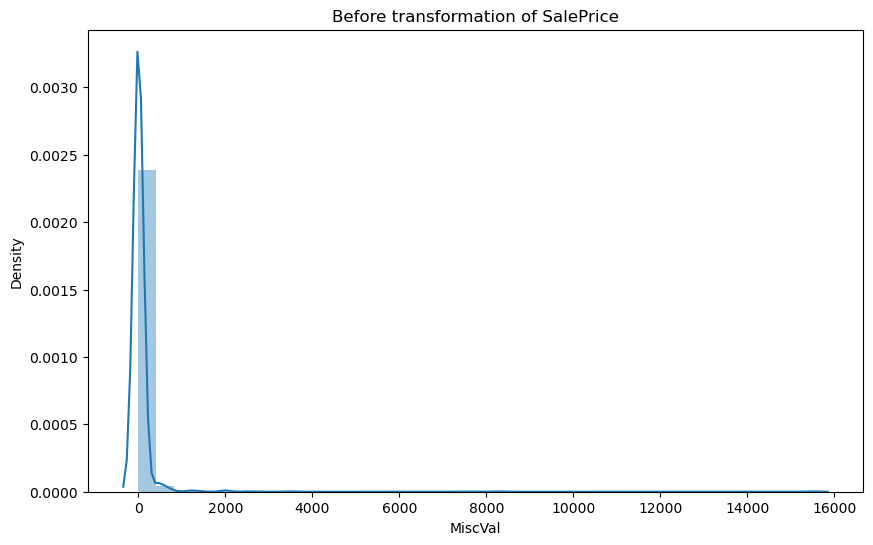

In [99]:
plt.figure(figsize=(10,6))
plt.title("Before transformation of SalePrice")
dist = sns.distplot(X['MiscVal'],norm_hist=False)

### Modeling

In [76]:
# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
#X_train = pd.get_dummies(X_train)
#X_valid = pd.get_dummies(X_valid)
#X_test = pd.get_dummies(X_test)
#X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
#X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [77]:
X_test.isnull().sum().sort_values(ascending=False)/X_test.shape[0]

MSZoning        0.0
Street          0.0
FireplaceQu     0.0
Fireplaces      0.0
KitchenQual     0.0
               ... 
MiscFeature     0.0
Fence           0.0
PavedDrive      0.0
GarageFinish    0.0
TotalSF         0.0
Length: 80, dtype: float64

In [6]:
my_model_2 = XGBRegressor(n_estimators=405,learning_rate=0.17)

# Fit the model
my_model_2.fit(X_train,y_train)#,
                          #early_stopping_rounds=5,
                          #eval_set=[(X_valid, y_valid)])

# Get predictions
predictions_2 = my_model_2.predict(X_valid)
mae_2 = mean_absolute_error(predictions_2,y_valid)

print("Mean Absolute Error:" , mae_2)

Mean Absolute Error: 16570.324633454624


In [17]:
preds_test = my_model_2.predict(X_test)
mae = mean_absolute_error(preds_test,benchmark.SalePrice)
mae 

54737.751376496555

### Pipeline

In [78]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),
                                          ('OneHot',OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, low_cardinality_cols)
    ])



In [94]:
model= XGBRegressor(n_estimators=405,learning_rate=0.17)
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 16721.23092358733


In [79]:
def get_score(n_estimators=405,learning_rate=0.17):
 
    model= XGBRegressor(n_estimators=n_estimators,learning_rate=learning_rate)
    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')
    return scores.mean()



In [80]:
l=[300,350,400,405,450,500,600]
score=[get_score(n_estimators=i) for i in l]

In [81]:
print(score)
best_est=l[score.index(min(score))]
print(best_est)

[16208.734032910526, 16208.311600755978, 16209.897889503414, 16210.196085701422, 16209.992743284458, 16210.255617945431, 16210.15889892474]
350


In [300]:
print(score)
best_est=l[score.index(min(score))]
print(best_est)

[16252.406576730062, 16255.66084192107, 16255.78705451599, 16255.842681791335, 16257.225004171283, 16256.965605208601, 16257.348250347015]
300


In [55]:
print(score)
best_est=l[score.index(min(score))]
print(best_est)

[17053.222205712507, 17050.066983787405, 17050.49911832297, 17050.50476720324, 17050.370968714087, 17050.62161538764, 17050.47532550928]
350


In [82]:
rates=[0.04,0.05,0.08,0.09,0.1,0.13,0.17]
score_rate=[get_score(n_estimators=best_est,learning_rate=i) for i in rates]

In [83]:
print(score_rate)
best_rate=rates[score_rate.index(min(score_rate))]
print(best_rate)

[15670.941671647799, 15750.883256608375, 15813.360324937297, 15882.085970110325, 15870.555752075436, 15977.487530208511, 16208.311600755978]
0.04


In [302]:
print(score_rate)
best_rate=rates[score_rate.index(min(score_rate))]
print(best_rate)

[15750.274122100514, 15730.96641513616, 15743.478824643753, 15637.796920085342, 15905.973247678949, 15959.70321295192, 16252.406576730062]
0.09


In [64]:
print(score_rate)
best_rate=rates[score_rate.index(min(score_rate))]
print(best_rate)

[16323.378479951696, 16195.483273635395, 16454.9493645042, 16395.304951446367, 16360.419101004989, 16366.52035650463, 16596.038479279643, 16856.203481309443, 17050.066983787405]
0.05


In [303]:
model= XGBRegressor(n_estimators=best_est,learning_rate=best_rate)
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
my_pipeline.fit(X_train, y_train,)                                  
preds_test = my_pipeline.predict(X_test)
mae = mean_absolute_error(preds_test,benchmark.SalePrice)
mae 

55414.25616892009

### Gridesearch

In [76]:
# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [77]:
param_lst = {
    'learning_rate' : [0.01,0.02,0.04,0.05,0.07,0.09,0.01,0.15, 0.17,0.2],
    'n_estimators' : [300,350,400,405,450,500,600, 1000, 2000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')
xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)

In [79]:
xgb_search = xgb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
model_tuned = XGBRegressor(**best_param)

In [84]:
best_param

{'reg_lambda': 0.001,
 'reg_alpha': 0.1,
 'n_estimators': 600,
 'min_child_weight': 20,
 'max_depth': 9,
 'learning_rate': 0.01}

In [81]:
model_tuned.fit(X_train, y_train)  

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=20, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [82]:
preds = model_tuned.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 17488.73507063356


In [83]:
preds_test = model_tuned.predict(X_test)
mae = mean_absolute_error(preds_test,benchmark.SalePrice)
print(mae) 

54865.80326463378


In [304]:
pred=benchmark
pred['SalePrice']=preds_test
pred.to_csv('ML_kaggle.csv',index=False)